In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import numpy as np
# Librerías para visualizacion
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
import re
import networkx as nx
from itertools import count
from itertools import combinations
from itertools import product
import statsmodels.api as sm
import urllib.request, json
!pip3 install geopandas
import geopandas
# -- set scientific notation to display numbers fully rather than exponential
pd.set_option('display.float_format', '{:.2f}'.format)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' 
import seaborn as sns
sns.set_style('whitegrid') # grids en dark background

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 100000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth',300)
print('librerías cargadas')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.1 MB/s 
     |████████████████████████████████| 16.6 MB 45.6 MB/s 
     |████████████████████████████████| 7.8 MB 44.2 MB/s 
librerías cargadas


#¿Qué es PRODY?

This is a measure calculated as the GDP per
capita of countries that produce it, weighted by their revealed comparative advantage in
that product.

Se importa la base desde drive

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
## Importamos la base ya preparada desde drive
df = pd.read_csv("/content/drive/MyDrive/eci/base/df_updated.csv")
print('dataframe cargado')

dataframe cargado


In [5]:
df.sample(n=6)
df.info()

,year,country_code,country_name,product_code,product_name,export_value
2183767,2001,BGR,Bulgaria,3102,"Fertilizers; mineral or chemical, nitrogenous",68960200
2978943,1995,MOZ,Mozambique,4204,"Articles of leather or of composition leather, of a kind used in machinery or mechanical appliances or for other technical uses",0
6541031,2014,JPN,Japan,8548,"Electrical parts; of machinery or apparatus, not specified or included elsewhere in chapter 85",1028466176
1198001,2000,SMR,San Marino,2501,Salt (including table salt and denatured salt); pure sodium chloride whether or not in aqueous solution; sea water,0
6432503,1999,DNK,Denmark,8530,"Signalling, safety or traffic control equipment; for railways, tramways, roads, inland waterways, parking facilities, port installations, airfields, excluding those of heading no. 8608",8046978
3566110,2019,HND,Honduras,5205,"Cotton yarn (other than sewing thread), containing 85% or more by weight of cotton, not put up for retail sale",8805865


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7373271 entries, 0 to 7373270
Data columns (total 6 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   year          int64 
 1   country_code  object
 2   country_name  object
 3   product_code  int64 
 4   product_name  object
 5   export_value  int64 
dtypes: int64(3), object(3)
memory usage: 337.5+ MB


#Calculo de RCA

In [6]:
## Función para el cálculo de RCA

def calc_rca(data,pais_col,prod_col,anio_col,value_col):
    """
      La función que calcula la RCA
    
    """
    print('Creando las combinaciones de país-producto-tiempo')
    df_all = pd.DataFrame(list(product(data[anio_col].unique(), data[pais_col].unique(),data[prod_col].unique())))
    df_all.columns=[anio_col,pais_col,prod_col]
    print('Se procede a fusionar los datos')
    df_all = pd.merge(df_all,data[[anio_col,pais_col,prod_col,value_col]],how='left',on=[anio_col,pais_col,prod_col])
    df_all.loc[df_all[value_col].isnull(),value_col] = 0

    # En esta parte se calculan propiedades
    print('calculando')
    df_all['Xcpt'] = df_all[value_col]
    df_all['Xct'] = df_all.groupby([pais_col, anio_col])[value_col].transform(sum)
    df_all['Xpt'] = df_all.groupby([prod_col, anio_col])[value_col].transform(sum)
    df_all['Xt'] = df_all.groupby([anio_col])[value_col].transform('sum')

    df_all['RCAcpt'] = (df_all['Xcpt']/df_all['Xct'])/(df_all['Xpt']/df_all['Xt']) #--> ecuación de las ventaja comparativa revelada RCA
    
    ## 0 si el producto / país tiene 0 exportaciones
    df_all.loc[df_all['RCAcpt'].isnull(),'RCAcpt'] = 0 
    # drop the properties 
    df_all.drop(['Xcpt','Xct','Xpt','Xt'],axis=1,inplace=True,errors='ignore')

    return df_all


In [7]:
df_rca = calc_rca(data=df,pais_col='country_name',prod_col='product_name',anio_col='year',value_col='export_value')

print('rca listo!!')

# Se muestran resultados
df_rca[0:10]

Creando las combinaciones de país-producto-tiempo
Se procede a fusionar los datos
calculando
rca listo!!


,year,country_name,product_name,export_value,RCAcpt
0,1995,Aruba,"Horses, asses, mules and hinnies; live",18008.00,0.13
1,1995,Aruba,Bovine animals; live,0.00,0.00
2,1995,Aruba,Swine; live,0.00,0.00
3,1995,Aruba,Sheep and goats; live,0.00,0.00
4,1995,Aruba,"Poultry; live, fowls of the species gallus domesticus, ducks, geese, turkeys and guinea fowls",0.00,0.00
5,1995,Aruba,"Animals, n.e.s. in chapter 01; live",2336.00,0.05
6,1995,Aruba,Meat of bovine animals; fresh or chilled,0.00,0.00
7,1995,Aruba,Meat of bovine animals; frozen,0.00,0.00
8,1995,Aruba,"Meat of swine; fresh, chilled or frozen",0.00,0.00
9,1995,Aruba,"Meat of sheep or goats; fresh, chilled or frozen",0.00,0.00


###Se filtra el dataframe solo para Ecuador

In [8]:

# Ecuador
df_rca[ (df_rca['country_name']=='Ecuador')].sort_values(by=['RCAcpt'],ascending=False)[['product_name','RCAcpt','year']][0:10]


,product_name,RCAcpt,year
2176048,"Bananas, including plantains; fresh or dried",266.11,2002
2476612,"Bananas, including plantains; fresh or dried",245.41,2003
1875484,"Bananas, including plantains; fresh or dried",244.05,2001
1574920,"Bananas, including plantains; fresh or dried",241.97,2000
1274356,"Bananas, including plantains; fresh or dried",234.63,1999
6384612,"Hat-shapes; plaited or made by assembling strips of any material, neither blocked to shape, nor with made brims, nor lined, nor trimmed",233.22,2016
6383944,"Bananas, including plantains; fresh or dried",231.67,2016
673228,"Bananas, including plantains; fresh or dried",229.02,1997
6684508,"Bananas, including plantains; fresh or dried",227.59,2017
6985072,"Bananas, including plantains; fresh or dried",225.52,2018


Se crea el objeto de valores de gpd per capita de los últimos 20 años

In [29]:
gdp_per_capita_ec = [{'year':2000, 'gdp_per_capita': '1445.3'}, 
                     {'year': 2001, 'gdp_per_capita': '1894.6'},
                     {'year': 2002, 'gdp_per_capita' : '2172.1' },
                      {'year': 2003, 'gdp_per_capita': '2425.9'},
                      {'year': 2004, 'gdp_per_capita': '2691.3'},
                     {'year': 2005, 'gdp_per_capita': '3002.1'},
                      {'year': 2006, 'gdp_per_capita': '3328.9'},
                        {'year': 2007, 'gdp_per_capita': '3567.8'},
                        {'year': 2008, 'gdp_per_capita': '4249'},
                         {'year': 2009, 'gdp_per_capita': '4231.6'},
                         {'year': 2010, 'gdp_per_capita': '4633.6'},
                         {'year': 2011, 'gdp_per_capita': '5200.6'},
                         {'year': 2012, 'gdp_per_capita': '5682'},
                         {'year': 2013, 'gdp_per_capita': '6056.3'},
                         {'year': 2014, 'gdp_per_capita': '6377.1'},
                         {'year': 2015, 'gdp_per_capita': '6124.5'},
                          {'year': 2016, 'gdp_per_capita': '6060.1'},
                          {'year': 2017, 'gdp_per_capita': '6213.5'},
                          {'year': 2018, 'gdp_per_capita': '6295.9'},
                          {'year': 2019, 'gdp_per_capita': '6222.5'},
                     ]

            
df_gdp_ec = pd.DataFrame(gdp_per_capita_ec)
# help(gdp_per_capita_ec)


In [31]:
df_gdp_ec[0:10]


,year,gdp_per_capita
0,2000,1445.3
1,2001,1894.6
2,2002,2172.1
3,2003,2425.9
4,2004,2691.3
5,2005,3002.1
6,2006,3328.9
7,2007,3567.8
8,2008,4249
9,2009,4231.6


The authors measure this sophistication indirectly by examining the wages of countries
who are intensive exporters of each product. First, they measure the sophistication of each
product, which they call PRODY, which is the revealed comparative advantage (RCA)-weighted
GDP per capita of each country that exports the good:



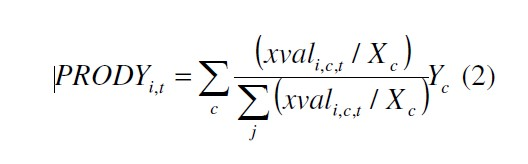